In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity
import math
from skimage import color, filters
import pandas as pd
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

2024-04-12 19:35:52.875294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 19:35:52.875396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 19:35:53.141430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [61]:
class PairedImageDataset(Dataset):
    def __init__(self, rootsA, rootsB, transform=None, split="train", test_size=0.2, random_state=42):
        """
        Args:
            rootsA (list of strings): Directories with all the images in trainA.
            rootsB (list of strings): Directories with all the images in trainB.
            transform (callable, optional): Optional transform to be applied on a sample.
            split (str, optional): Which split to use ('train', 'val', 'test').
            test_size (float, optional): Proportion of the dataset to include in the test split.
            random_state (int, optional): Controls the shuffling applied to the data before applying the split.
        """
        self.transform = transform

        # Accumulate all file paths from the given roots
        filepathsA = []
        filepathsB = []
        for rootA, rootB in zip(rootsA, rootsB):
            filenames = sorted(os.listdir(rootA))
            filepathsA += [os.path.join(rootA, f) for f in filenames]
            filepathsB += [os.path.join(rootB, f) for f in filenames]

        # Split the data
        full_size = len(filepathsA)
        test_split_size = int(full_size * test_size)
        train_val_size = full_size - test_split_size
        val_split_size = int(train_val_size * test_size)  # Further split the training into training and validation

        if split == "train":
            self.filepathsA, _ = train_test_split(filepathsA, test_size=test_split_size + val_split_size, random_state=random_state)
            self.filepathsB, _ = train_test_split(filepathsB, test_size=test_split_size + val_split_size, random_state=random_state)
        elif split == "val":
            _, temp_filepathsA = train_test_split(filepathsA, test_size=test_split_size + val_split_size, random_state=random_state)
            self.filepathsA, _ = train_test_split(temp_filepathsA, test_size=test_split_size, random_state=random_state)
            _, temp_filepathsB = train_test_split(filepathsB, test_size=test_split_size + val_split_size, random_state=random_state)
            self.filepathsB, _ = train_test_split(temp_filepathsB, test_size=test_split_size, random_state=random_state)
        elif split == "test":
            _, temp_filepathsA = train_test_split(filepathsA, test_size=test_split_size, random_state=random_state)
            self.filepathsA, _ = train_test_split(temp_filepathsA, test_size=500, random_state=random_state)
            _, temp_filepathsB = train_test_split(filepathsB, test_size=test_split_size, random_state=random_state)
            self.filepathsB, _ = train_test_split(temp_filepathsB, test_size=500, random_state=random_state)

    def __len__(self):
        return len(self.filepathsA)

    def __getitem__(self, idx):
        imageA = Image.open(self.filepathsA[idx]).convert('RGB')
        imageB = Image.open(self.filepathsB[idx]).convert('RGB')

        if self.transform:
            imageA = self.transform(imageA)
            imageB = self.transform(imageB)

        return imageA, imageB


In [62]:
# class PairedImageDataset(Dataset):
#     def __init__(self, rootsA, rootsB, transform=None):
#         """
#         Args:
#             rootsA (list of strings): Directories with all the images in trainA.
#             rootsB (list of strings): Directories with all the images in trainB.
#             transform (callable, optional): Optional transform to be applied on a sample.
#         """
#         self.transform = transform

#         # Accumulate all file paths from the given roots
#         self.filepathsA = []
#         self.filepathsB = []
#         for rootA, rootB in zip(rootsA, rootsB):
#             filenames = sorted(os.listdir(rootA))
#             self.filepathsA += [os.path.join(rootA, f) for f in filenames]
#             self.filepathsB += [os.path.join(rootB, f) for f in filenames]

#     def __len__(self):
#         return len(self.filepathsA)

#     def __getitem__(self, idx):
#         imageA = Image.open(self.filepathsA[idx]).convert('RGB')
#         imageB = Image.open(self.filepathsB[idx]).convert('RGB')

#         if self.transform:
#             imageA = self.transform(imageA)
#             imageB = self.transform(imageB)

#         return imageA, imageB


In [63]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim, kernel_size = (4,4), stride =2, padding = 1):
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList()

        # layer 1
        self.layers.append(
            nn.Conv2d(
                in_channels=hdim[0],
                out_channels=hdim[1],
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            )
        )

        self.layers.append(nn.LeakyReLU(0.2))
        self.layers.append(nn.Identity())

        # the rest of the layers
        for in_out in range(1, (len(hdim) - 1)):
            self.layers.append(
                nn.Conv2d(
                    in_channels=hdim[in_out],
                    out_channels=hdim[(in_out + 1)],
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                )
            )

            self.layers.append(nn.BatchNorm2d(hdim[in_out + 1]))

            self.layers.append(nn.LeakyReLU(0.2))


    def forward(self, x):

        SkipConnections = []

        for i, layer in enumerate(self.layers):
            # print(layer)
            x = layer.forward(x)
            if (i + 1) % 3 == 0 and i < 21:
#                 print("Layer e: and shape ",i, x.shape)
                SkipConnections.append(x)
        return x, SkipConnections

In [64]:
#decoder
class Decoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim_in, hdim_out, kernel_size = (4,4), stride =2, padding= 1):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList()

        # layers 1 to 3 with dropout
        for in_out in range(0, 3):
            self.layers.append(
                nn.ConvTranspose2d(
                    in_channels=hdim_in[in_out],
                    out_channels=hdim_out[(in_out + 1)],
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                )
            )

            self.layers.append(nn.BatchNorm2d(hdim_out[in_out + 1]))
            self.layers.append(nn.Dropout2d(0.5))
            self.layers.append(nn.ReLU())

        # the rest of the layers 
        for in_out in range(3, (len(hdim_in) - 2)):
            self.layers.append(
                nn.ConvTranspose2d(
                    in_channels=hdim_in[in_out],
                    out_channels=hdim_out[(in_out + 1)],
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                )
            )

            self.layers.append(nn.BatchNorm2d(hdim_out[in_out + 1]))
            self.layers.append(nn.Identity())
#             self.layers.append(nn.Dropout2d(0.5))
            self.layers.append(nn.ReLU())
    
        self.layers.append(
                    nn.ConvTranspose2d(
                        in_channels=hdim_in[len(hdim_in)- 2],
                        out_channels=hdim_out[len(hdim_in) - 1],
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                    )
                )
        self.layers.append(nn.Tanh())
        
            
    def forward(self, z, SkipConnections):
        
        EncoderIndex = 3/4
        SkipConnections.reverse()
        j = 0

        for i, layer in enumerate(self.layers):
            if (i + 1) % 4 == 0 and i < 28:
#                 print("skipconn layer j:", j)
#                 j = int(EncoderIndex * i)
#                 z = layer.forward(torch.add(z, SkipConnections[j]))
#                 print("layer z.shape", z.shape)
#                 print("layer other.shape", SkipConnections[j].shape)
                z = layer.forward(torch.cat((z,SkipConnections[j]), 1)) 
                j += 1
                    
            else:
                z = layer.forward(z)
                
#         z = torch.tanh(z)
#         z = z * 255
        return z

In [65]:
#Generator
class Generator(nn.Module):
    def __init__(self,
                latent_dims,
                s_img,
                hdim_e,
                hdim_d_input,
                hdim_d_output,
                kernel_size, 
                padding):
        super(Generator, self).__init__()

        self.encoder = Encoder(
            latent_dims=latent_dims,
            s_img=s_img,hdim=hdim_e,
            kernel_size= kernel_size,
            padding= padding)
        self.decoder = Decoder(
            latent_dims=latent_dims,
            s_img=s_img, 
            hdim_in=hdim_d_input, 
            hdim_out=hdim_d_output,
            kernel_size=kernel_size, 
            padding=padding)

    def forward(self, x):

        z, skipConnections = self.encoder(x)
        # print(f"the shape of encoder is {z.shape}")
        y = self.decoder(z, skipConnections)

        return y

In [66]:
class Discriminator(nn.Module):
    
    def __init__(self, latent_dims, s_img, hdim, kernel_size=(4, 4), stride=2):
        
        super(Discriminator, self).__init__()

        ########################################################################
        #    Create the necessary layers                                 #
        ########################################################################

        self.layers = nn.ModuleList()
        
        # Input layer dim -- down1
        self.layers.append(nn.Conv2d(in_channels=6, out_channels=64, kernel_size=kernel_size, stride=2, padding=1))
        # Batchnorm
        self.layers.append(nn.BatchNorm2d(64))
        
        self.layers.append(nn.LeakyReLU(0.2))

        # Hidden to hidden convolution -- down2 and down 3
        for i in range(0, 2):
            self.layers.append(nn.Conv2d(in_channels=hdim[i],
                                             out_channels=hdim[i + 1],
                                             kernel_size=kernel_size, stride = stride, padding=1))
            # Batchnorm
            self.layers.append(nn.BatchNorm2d(hdim[i+1]))
            self.layers.append(nn.LeakyReLU(0.2))
            
            

        # Pad with zeroes
        self.layers.append(nn.ZeroPad2d(padding=(1,1,1,1)))
        
#         # Batchnorm
#         self.layers.append(nn.BatchNorm2d(hdim[3]))
#         self.layers.append(nn.LeakyReLU(0.2))
        
        # Conv2D
        self.layers.append(nn.Conv2d(in_channels=hdim[3],
                                             out_channels=hdim[4],
                                             kernel_size=kernel_size, stride = 1))

        # Batchnorm
        self.layers.append(nn.BatchNorm2d(hdim[4]))
        self.layers.append(nn.LeakyReLU(0.2))

        # Zeropad2
        self.layers.append(nn.ZeroPad2d(padding=(1,1,1,1)))

        
#         # Batchnorm
        self.layers.append(nn.BatchNorm2d(hdim[5]))
        self.layers.append(nn.LeakyReLU(0.2))

        #Conv2D 2
        self.layers.append(nn.Conv2d(in_channels=hdim[5],
                                             out_channels=hdim[6],
                                             kernel_size=kernel_size, stride = 1))
#         # Batchnorm
        self.layers.append(nn.BatchNorm2d(hdim[6]))
        self.layers.append(nn.LeakyReLU(0.2))
        self.layers.append(nn.Sigmoid())

#         self.Leakyrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):

#         for n_layer, layer in enumerate(self.layers):
#             ## The fourth layer first has a batchnorm and then a Leakyrelu
#             if n_layer != 4:
#                 x = self.Leakyrelu(layer(x))
#             else:
#                 x = layer(x)
#         return x
    
        for n_layer, layer in enumerate(self.layers):
            x = layer(x)
        return x

In [67]:
def train_gan(train_loader, net_gen, net_dis, optimizer_gen, optimizer_dis, criterion_l1, criterion_bce, pin_memory , device = 'cpu'):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
        device: whether the network runs on cpu or gpu
    """
    
#     labels = torch.zeros(30, 30)

    avg_loss_gen = 0
    avg_loss_dis = 0
    avg_L1_loss = 0
    avg_bce_loss_gen = 0

    # iterate through batches
    for i, data in enumerate(train_loader):
        
        use_generator = False
        
        # get the inputs; data is a list of [inputs, labels]
        under_water_img, ground_truth = data
        
        # convert the inputs to run on GPU if set
        if device != 'cpu':
            under_water_img, ground_truth = under_water_img.cuda(non_blocking=pin_memory), ground_truth.cuda(non_blocking=pin_memory)
            

        # zero the parameter gradients
        optimizer_gen.zero_grad()
        optimizer_dis.zero_grad()
        
#         loss_gen_tot = 0
        #generator_output = generator(input)
        outputs_gen = net_gen.forward(under_water_img)
    
#########loss generator############################################################################################################################

        # forward + backward + optimize
#         discriminator_generated_output = discriminator([input, generator_output])
        inputs_dis_fake = torch.cat((under_water_img, outputs_gen), dim = 1)
        outputs_dis_fake = net_dis.forward(inputs_dis_fake)
        
#         gan_loss = CE(ones_like(discriminator_generated_output), discriminator_generated_output)
        loss_gen_bce = criterion_bce(outputs_dis_fake, torch.ones_like(outputs_dis_fake))# Dit is niet kapot!!!!!!!
        l1 = criterion_l1(outputs_gen,ground_truth)
        loss_gen_l1 = torch.mul(l1,100)
        # total_generator_loss = gan_loss + (100 * l1_loss)
        loss_gen_tot = torch.add(loss_gen_bce, loss_gen_l1)
        loss_gen_tot.backward()
        optimizer_gen.step()
        
####################################################################################################################################################



#########loss discriminator#########################################################################################################################
            
        loss_dis = 0
    
        n_samples, channels, s_img, _ = outputs_gen.size()
    
        ones = torch.ones(n_samples, 1, 30, 30).to(device)
        zeros = torch.zeros(n_samples, 1, 30, 30).to(device)
#         labels = torch.cat((zeros, ones), dim = 0).to(device)

#         set_fake = inputs_dis_fake.detach()
        set_true = torch.cat((under_water_img, ground_truth), dim = 1)
#         x = torch.cat((set_fake, set_true), dim = 0).to(device)

        outputs_dis_true = net_dis.forward(set_true)
#         output_probabilities = torch.sigmoid(outputs)

#         loss_dis_tot = criterion_bce(output_probabilities, labels)
        
        loss_dis_bce_fake = criterion_bce(outputs_dis_fake.detach(), zeros)
        loss_dis_bce_true = criterion_bce(outputs_dis_true, ones.detach())
        loss_dis_tot = torch.add(loss_dis_bce_fake, loss_dis_bce_true)
        
        loss_dis_tot.backward()
        optimizer_dis.step()
        
#########loss discriminator#########################################################################################################################

        # keep track of loss and accuracy
        avg_loss_gen += loss_gen_tot
        avg_loss_dis += loss_dis_tot
        avg_L1_loss += l1
        avg_bce_loss_gen += loss_gen_bce
        

    return avg_loss_gen/len(train_loader), avg_loss_dis/len(train_loader),avg_L1_loss/len(train_loader), avg_bce_loss_gen/len(train_loader)


def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device

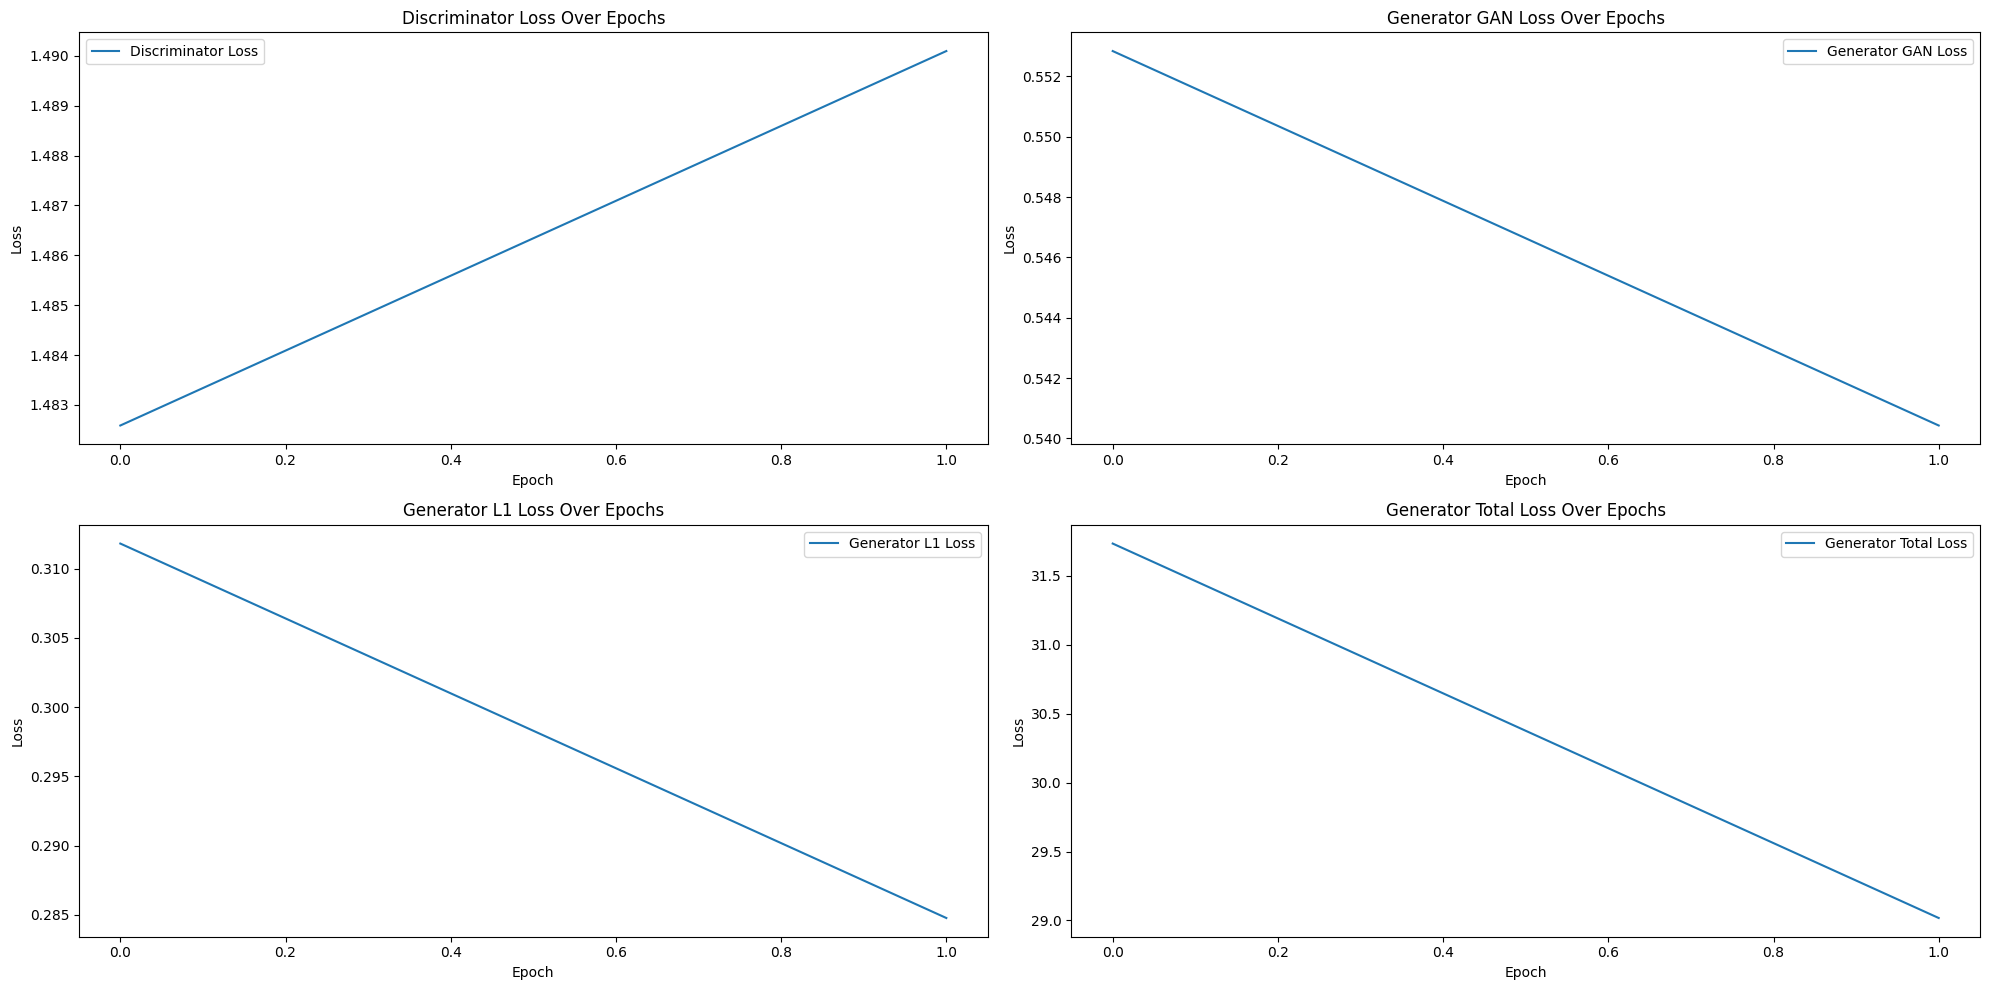

  1%|▏         | 2/150 [04:22<5:23:28, 131.14s/it]


KeyboardInterrupt: 

In [68]:
if __name__ == "__main__":
    # show_images()
    torch.cuda.empty_cache()
    num_workers = 2
    pin_memory = True
    batch_size = 64
    n_samples, in_channels, s_img, latent_dims, padding = 1, 3, 256, 512,1
    hdim_e = [3, 64, 128, 256, 512, 512, 512, 512, 512] #choose hidden dimension encoder
    hdim_d_output = [512, 512, 512, 512, 512, 256, 128, 64, 3]
    hdim_d_input = [512, 1024, 1024, 1024, 1024, 512, 256, 128, 3] #choose hidden dimension decoder
#     hdim_d_input = hdim_d_output
    in_channels_dis = 6 # 6 for two images
    hdim_dis = [64, 128, 256, 256, 512, 512, 1] #choose hidden dimension discriminator
    output_shape = (n_samples, 1, 30, 30)
    
    kernel_size = (4,4)

   # Define the transformation pipeline with added jitter
    transform = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.NEAREST),  # Resize to 256x256 using nearest neighbor method
        transforms.RandomCrop(256),  # Apply random cropping to introduce jitter
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.ToTensor(),  # Convert images to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])

    # Specify the root directories for trainA and trainB for all datasets
    rootsA = [
        r'/kaggle/input/EUVP/Paired/underwater_dark/trainA',
        r'/kaggle/input/EUVP/Paired/underwater_imagenet/trainA',
        r'/kaggle/input/EUVP/Paired/underwater_scenes/trainA'
    ]
    rootsB = [
        r'/kaggle/input/EUVP/Paired/underwater_dark/trainB',
        r'/kaggle/input/EUVP/Paired/underwater_imagenet/trainB',
        r'/kaggle/input/EUVP/Paired/underwater_scenes/trainB'
    ]

    # Initialize the combined dataset
#     combined_dataset = PairedImageDataset(rootsA, rootsB, transform=transform)
    
    # Initialize datasets for each split
    training_dataset = PairedImageDataset(rootsA, rootsB, transform=transform, split="train")
    validation_dataset = PairedImageDataset(rootsA, rootsB, transform=transform, split="val")
    test_dataset = PairedImageDataset(rootsA, rootsB, transform=transform, split="test")

    # Initialize DataLoaders for each dataset
    training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)


#     # Initialize a DataLoader for the combined dataset
#     combined_EUVP_data = DataLoader(
#         combined_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=num_workers,
#         pin_memory=pin_memory
#     )

    # Now you can fetch a batch from the combined dataset
    images_a, images_b = next(iter(training_loader))

    #Set the number of dimensions of the latent space
    # latent_dims = [2,3]
    s_img = np.size(images_a[1][0], axis = 1) #get image size (height = width) from a data sample

    #initialize generator model
    model_gen = Generator(latent_dims=latent_dims,
                        s_img=s_img,
                        hdim_e=hdim_e, 
                        hdim_d_input=hdim_d_input,
                        hdim_d_output=hdim_d_output, 
                        padding=padding,
                        kernel_size=kernel_size)
    #intit dis
    model_dis = Discriminator(latent_dims, s_img, hdim_dis)

    # Create a writer to write to Tensorboard
    writer = SummaryWriter()

    #Create instance of Autoencoder
    device = try_gpu()
    print(device)
    
    if torch.cuda.is_available():
        model_gen= nn.DataParallel(model_gen)
        model_gen.to(device)
        model_dis = nn.DataParallel(model_dis)
        model_dis.to(device)

    # Create loss function and optimizer
    criterion_l1 = F.l1_loss 
    criterion_bce = F.binary_cross_entropy
#     criterion_l1 = nn.L1Loss()
#     criterion_bce = nn.CrossEntropyLoss
    
    optimizer_gen = optim.Adam(model_gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_dis = optim.Adam(model_dis.parameters(), lr=2e-4, betas=(0.5, 0.999))

    # Set the number of epochs to for training
    epochs = 150
    
    plt.ion()  # Enable interactive mode
    
    losses_gen = []
    losses_dis = [] 
    losses_l1 = []
    losses_bce = []
    
    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
        # Train on data

        train_loss_gen, train_loss_dis, train_loss_l1, train_loss_gen_bce = train_gan(training_loader, model_gen,model_dis, optimizer_gen, optimizer_dis, criterion_l1, criterion_bce, pin_memory, device)
              
#           Write metrics to Tensorboard
        writer.add_scalars("Discriminator Loss over Epochs", {'Train': train_loss_dis}, epoch)
        writer.add_scalars("Generator GAN Loss over Epochs", {'Train': train_loss_gen}, epoch)
        writer.add_scalars("Generator L1 Loss over Epochs", {'Train': train_loss_l1}, epoch)
        writer.add_scalars("Generator Total Loss over Epochs", {'Train': train_loss_gen_bce}, epoch)
        
        losses_gen.append(train_loss_gen.item())
        losses_dis.append(train_loss_dis.item())
        losses_l1.append(train_loss_l1.item())
        losses_bce.append(train_loss_gen_bce.item())
        
#         Visualization code
        clear_output(wait=True)
        # Set the figure size larger to accommodate four subplots
        plt.figure(figsize=(20, 10))

        # Discriminator Loss
        plt.subplot(2, 2, 1)  # 2 rows, 2 cols, subplot 1
        plt.plot(losses_dis, label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Discriminator Loss Over Epochs')
        plt.legend()

        # Generator GAN Loss
        plt.subplot(2, 2, 2)  # 2 rows, 2 cols, subplot 2
        plt.plot(losses_bce, label='Generator GAN Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Generator GAN Loss Over Epochs')
        plt.legend()

        # Generator L1 Loss
        plt.subplot(2, 2, 3)  # 2 rows, 2 cols, subplot 3
        plt.plot(losses_l1, label='Generator L1 Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Generator L1 Loss Over Epochs')
        plt.legend()

        # Generator Total Loss (BCE)
        plt.subplot(2, 2, 4)  # 2 rows, 2 cols, subplot 4
        plt.plot(losses_gen, label='Generator Total Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Generator Total Loss Over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    # save
    torch.save(model_gen, 'model.pth')
    torch.save(model_gen.state_dict(), 'model_dict.pth')
        # save
    torch.save(model_dis, 'model_dis.pth')
    torch.save(model_dis.state_dict(), 'model_dict_dis.pth')
    
    plt.ioff()  # Disable interactive mode
    writer.close()

In [ ]:
## evaluation metrics

def plipsum(i,j,gamma=1026):
    return i + j - i * j / gamma

def plipsub(i,j,k=1026):
    return k * (i - j) / (k - j)

def plipmult(c,j,gamma=1026):
    if 1 - j / gamma < 0:
        c = int(c)
    return gamma - gamma * (1 - j / gamma)**c

def psnr(a,b):
    #pnsr
    mse = np.mean((a-b)**2)
    psnr = 10*math.log10(255**2/mse)
    return psnr

def ssim(a, b):
    # SSIM calculation with explicit win_size
    ssim = structural_similarity(a, b, multichannel=True, win_size=None, data_range = 1.0, channel_axis = 0)
    return ssim

def uiqm(a):
    rgb = a
    gray = color.rgb2gray(a, channel_axis = 0)

    # UIQM
    p1 = 0.0282
    p2 = 0.2953
    p3 = 3.5753

    #1st term UICM
    rg = rgb[:,:,0] - rgb[:,:,1]
    yb = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]
    rgl = np.sort(rg,axis=None)
    ybl = np.sort(yb,axis=None)
    al1 = 0.1
    al2 = 0.1
    T1 = int(al1 * len(rgl))
    T2 = int(al2 * len(rgl))
    rgl_tr = rgl[T1:-T2]
    ybl_tr = ybl[T1:-T2]

    urg = np.mean(rgl_tr)
    s2rg = np.mean((rgl_tr - urg) ** 2)
    uyb = np.mean(ybl_tr)
    s2yb = np.mean((ybl_tr- uyb) ** 2)

    uicm =-0.0268 * np.sqrt(urg**2 + uyb**2) + 0.1586 * np.sqrt(s2rg + s2yb)

    #2nd term UISM (k1k2=8x8)
    Rsobel = rgb[:,:,0] * filters.sobel(rgb[:,:,0])
    Gsobel = rgb[:,:,1] * filters.sobel(rgb[:,:,1])
    Bsobel = rgb[:,:,2] * filters.sobel(rgb[:,:,2])

    Rsobel=np.round(Rsobel).astype(np.uint8)
    Gsobel=np.round(Gsobel).astype(np.uint8)
    Bsobel=np.round(Bsobel).astype(np.uint8)

    Reme = eme(Rsobel)
    Geme = eme(Gsobel)
    Beme = eme(Bsobel)

    uism = 0.299 * Reme + 0.587 * Geme + 0.114 * Beme

    #3rd term UIConM
    uiconm = logamee(gray)

    uiqm = p1 * uicm + p2 * uism + p3 * uiconm
    return uiqm


def eme(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)
    
    eme = 0
    w = 2. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]
            
            block = ch[xlb:xrb,ylb:yrb]

            blockmin = float(np.min(block))
            blockmax = float(np.max(block))


            if blockmin == 0: blockmin+=1
            if blockmax == 0: blockmax+=1
            eme += w * math.log(blockmax / blockmin)
    return eme

def logamee(ch,blocksize=10): ## blocksize op 10

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)
    
    s = 0
    w = 1. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]
            
            block = ch[xlb:xrb,ylb:yrb]
            blockmin = float(np.min(block))
            blockmax = float(np.max(block))

            top = plipsub(blockmax,blockmin)
            bottom = plipsum(blockmax,blockmin)

            m = top/bottom
            if m <= 0.:
                s+=0
            else:
                s += (m) * np.log(m)

    return plipmult(w,s)

for j, data in enumerate(test_loader):

    input, gt = data

In [4]:
## Load trained model

# Path to the PTH file
pth_file_path = r'/kaggle/input/model-gen/model.pth'
# Load the model checkpoint into a variable
model_gen = torch.load(pth_file_path)

AttributeError: Can't get attribute 'Generator' on <module '__main__'>

In [ ]:
psnr_arr = []
ssim_arr = []
uiqm_arr = []
img_count = 0

for _, data in enumerate(test_loader):
    # 1 batch of 500 images
    inputs, labels = data
    inputs, labels = inputs, labels
    y_out = model_gen.forward(inputs)
    test_samples = y_out.size(0)

    for i in range(test_samples):
        img_count += 1
        if img_count == 500:
            break
        gt_img = labels[i, :, :, :].cpu().detach().numpy()
        out_img = y_out[i, :, :, :].cpu().detach().numpy()

        psnr_arr.append(psnr(out_img, gt_img)) 
        ssim_arr.append(ssim(out_img, gt_img))
        uiqm_arr.append(uiqm(out_img))

    if img_count == 500: ## We moeten de lengte van test_loader op 500 stellen
        break

psnr_mean = np.mean(psnr_arr)
psnr_std = np.std(psnr_arr)
ssim_mean = np.mean(ssim_arr)
ssim_std = np.std(ssim_arr)
uiqm_mean = np.mean(uiqm_arr)
uiqm_std = np.std(uiqm_arr)

data = {
    'Metric': ['PSNR', 'SSIM', 'UIQM'],
    'Mean': [psnr_mean, ssim_mean, uiqm_mean],
    'Std': [psnr_std, ssim_std, uiqm_std]
}

df = pd.DataFrame(data)
print(df)
df.to_csv('/kaggle/working/test2/evaluation.csv')
print(img_count) ## deze moet op 500 komen


In [ ]:
torch.cuda.empty_cache()
# make a folder
count = 0
image_counter = 10
path = '/kaggle/working/test2'
path_loop = None
# Initialize DataLoader
EUVP_data = DataLoader(training_loader, batch_size=8, shuffle=False, num_workers=4)

print("start printing")
# Store somep images
for i, data in enumerate(validation_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    y_out = model_gen.forward(inputs)
#     y_out = torch.tanh(y_out)

    for x in range(len(inputs) - 1):
        path_loop = f"{path}/test{count}"
        if not (os.path.exists(path_loop) and os.path.isdir(path_loop)):
            os.makedirs(path_loop)

        name = (f'{path_loop}/image_in{count}.jpg')
        save_image(inputs[x], name)
        name = (f'{path_loop}/image_out{count}.jpg')
        save_image(y_out[x], name)
        name = (f'{path_loop}/image_truth{count}.jpg')
        save_image(labels[x], name)
        count += 1

print("Printing done")


In [ ]:
import zipfile
import os
from IPython.display import FileLink

torch.cuda.empty_cache()
def zip_dir(directory = os.curdir, file_name = 'resutls.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

zip_dir()



In [ ]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/runs

In [ ]:
 %reload_ext tensorboard

In [ ]:
!kill 292